In [13]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
# connect to the database
conn = sqlite3.connect('../max-experiments/itinerary-scraping/journeys.db')
cursor = conn.cursor()

# get all outages
cursor.execute('SELECT * FROM outages')
outages = cursor.fetchall()
# outages

[('828',
  'stop_point:tcl:SP:30205',
  'unavailable',
  '2024-05-25T17:28:00+02:00',
  '{"cause": {"label": "Acc\\u00e8s ferm\\u00e9 pour travaux"}, "effect": {"label": "."}, "periods": [{"begin": "20240525T000000", "end": "20240525T193000"}]}'),
 ('503',
  'stop_point:tcl:SP:46036',
  'unavailable',
  '2024-05-25T17:28:00+02:00',
  '{"cause": {"label": "Panne"}, "effect": {"label": "Acc\\u00e8s \\u00e0 la station et acc\\u00e8s SNCF impossibles"}, "periods": [{"begin": "20240524T000000", "end": "20240530T193000"}]}'),
 ('242',
  'stop_point:tcl:SP:30156',
  'unavailable',
  '2024-05-25T17:28:00+02:00',
  '{"cause": {"label": "Panne"}, "effect": {"label": "Direction Vaulx-en-Velin La Soie, prendre l\'autre ascenseur et passer par la ligne C"}, "periods": [{"begin": "20240525T000000", "end": "20240525T193000"}]}'),
 ('2604',
  'stop_point:tcl:SP:46051',
  'unavailable',
  '2024-05-25T17:28:00+02:00',
  '{"cause": {"label": "Panne"}, "effect": {"label": "."}, "periods": [{"begin": "2024

In [20]:
cursor.execute('SELECT * FROM outages')
outages = cursor.fetchall()

cursor.execute('SELECT * FROM journeys')
journeys = cursor.fetchall()

# number of outages
print(len(outages))

print('---')
print("% of journeys with outages:", round(len(outages)/len(journeys) * 100, 3))

183
---
% of journeys with outages: 0.104


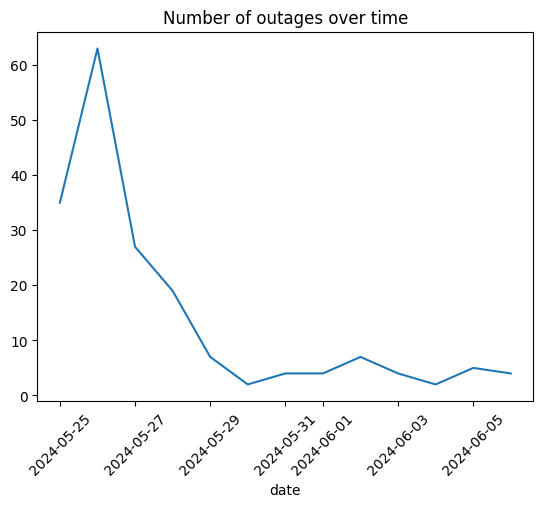

In [45]:
outages_df = pd.DataFrame(outages, columns=['outage_id', 'stop_id', 'effect', 'updated_at', 'outage_data'])

outages_df['updated_at'] = pd.to_datetime(outages_df['updated_at'])
outages_df['date'] = outages_df['updated_at'].dt.date

# plot number of outages over time
outages_df.groupby('date').size().plot()
plt.title('Number of outages over time')
# rotate x-axis labels
plt.xticks(rotation=45)
plt.show()


In [17]:
# average length of outages
durations = []
for row in outages_df['outage_data']:
    row = row.split('begin')[1]
    
    # format is now ": "20240525T000000", "end": "20240525T193000"}]}
    # we want to extract the two dates and calculate the difference
    row = row[4:]   # cut off the first ": "
    
    # begin is the next 15 characters
    begin = row[:15]
    row = row[26:]      # cut to the end date
    
    # end is the next 15 characters
    end = row[:15]
    
    # calculate the difference
    begin = pd.to_datetime(begin)
    end = pd.to_datetime(end)
    
    # convert to seconds
    duration = (end - begin).total_seconds()
    durations.append(duration)
    
print('Average outage duration:', round(sum(durations)/len(durations), 3), 'seconds')
print('Median outage duration:', pd.Series(durations).median(), 'seconds')
print('----------')

q1 = pd.Series(durations).quantile(0.25)
q3 = pd.Series(durations).quantile(0.75)
iqr = q3 - q1

# remove outliers
durations_no_outliers = [duration for duration in durations if duration < q3 + 1.5*iqr]
print('Average outage duration (no outliers):', round(sum(durations_no_outliers)/len(durations_no_outliers), 3), 'seconds')
print('Median outage duration (no outliers):', pd.Series(durations_no_outliers).median(), 'seconds')

outages_df['duration'] = durations # add duration to the dataframe

Average outage duration: 469131.148 seconds
Median outage duration: 30600.0 seconds
----------
Average outage duration (no outliers): 42197.605 seconds
Median outage duration (no outliers): 27000.0 seconds


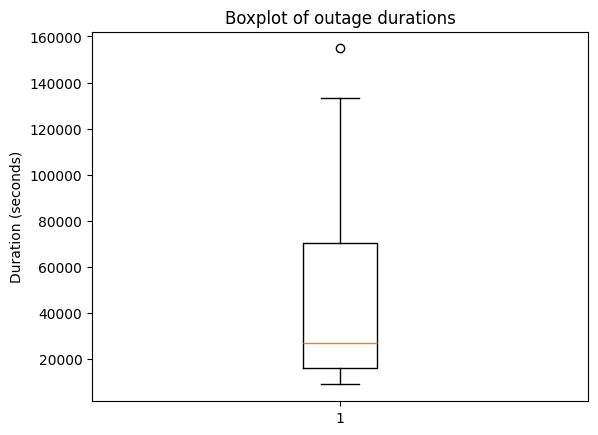

In [18]:
# boxplot of outage durations
plt.boxplot(durations_no_outliers)
plt.title('Boxplot of outage durations')
plt.ylabel('Duration (seconds)')
plt.show()

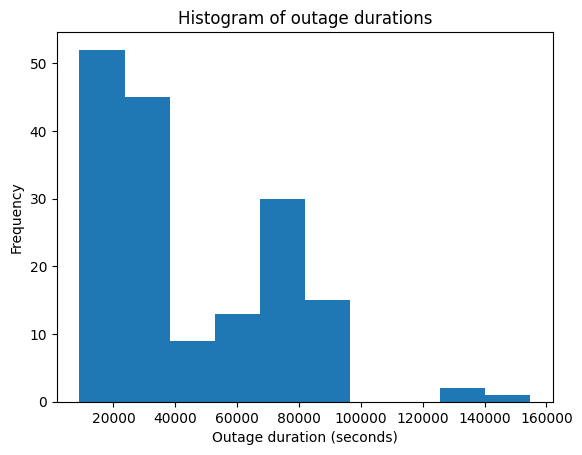

In [36]:
# histogram of outage durations
pd.Series(durations_no_outliers).hist(bins=10)
plt.title('Histogram of outage durations')
plt.xlabel('Outage duration (seconds)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [25]:
# frequency of outages
from collections import Counter
outage_freq = Counter([outage[1] for outage in outages])
print(outage_freq)

# get the stop names
cursor.execute('SELECT * FROM stops')
stops = cursor.fetchall()

stop_names = {}
for stop in stops:
    stop_names[stop[0]] = stop[1]
    
# get the most frequent outages
most_frequent_outages = sorted(outage_freq.items(), key=lambda x: x[1], reverse=True)
print(most_frequent_outages)
# for stop_id, freq in most_frequent_outages:
#     print(stop_names[stop_id], freq)


Counter({'stop_point:tcl:SP:46024': 8, 'stop_point:tcl:SP:30205': 5, 'stop_point:tcl:SP:46051': 5, 'stop_point:tcl:SP:46033': 5, 'stop_point:tcl:SP:46036': 4, 'stop_point:tcl:SP:48137': 4, 'stop_point:tcl:SP:30209': 4, 'stop_point:tcl:SP:30189': 4, 'stop_point:tcl:SP:30197': 4, 'stop_point:tcl:SP:46058': 4, 'stop_point:tcl:SP:30445': 4, 'stop_point:tcl:SP:30211': 4, 'stop_point:tcl:SP:30156': 3, 'stop_point:tcl:SP:46053': 3, 'stop_point:tcl:SP:46054': 3, 'stop_point:tcl:SP:46026': 3, 'stop_point:tcl:SP:46028': 3, 'stop_point:tcl:SP:30448': 3, 'stop_point:tcl:SP:30198': 3, 'stop_point:tcl:SP:30200': 3, 'stop_point:tcl:SP:30208': 3, 'stop_point:tcl:SP:46060': 3, 'stop_point:tcl:SP:46025': 3, 'stop_point:tcl:SP:42744': 3, 'stop_point:tcl:SP:42738': 3, 'stop_point:tcl:SP:30185': 3, 'stop_point:tcl:SP:36394': 3, 'stop_point:tcl:SP:30191': 3, 'stop_point:tcl:SP:30199': 3, 'stop_point:tcl:SP:30103': 3, 'stop_point:tcl:SP:30447': 3, 'stop_point:tcl:SP:30210': 3, 'stop_point:tcl:SP:46031': 2, '

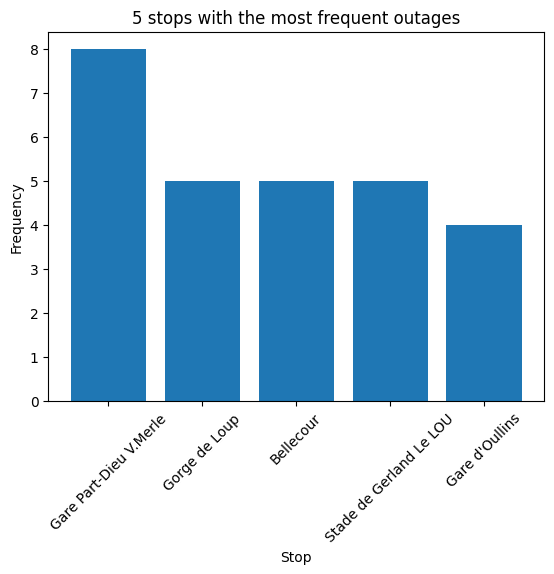

In [33]:
# Plot the 5 stops with the most frequent outages
top_5 = most_frequent_outages[:5]
top_5_names = [stop_names[stop_id] for stop_id, freq in top_5]
top_5_freq = [freq for stop_id, freq in top_5]

plt.bar(top_5_names, top_5_freq)
plt.title('5 stops with the most frequent outages')
plt.xlabel('Stop')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()